# Working with TS

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
import matplotlib.dates as mdates

## Dataset

In [2]:
# Generate folded data per month
data = {
    "issue_date": [
        "2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04", "2023-01-05",
        "2023-01-06", "2023-01-07", "2023-01-09", "2023-01-10", "2023-01-11",
        "2023-01-12", "2024-01-01", "2024-01-02", "2024-01-03", "2024-01-04",
        "2024-01-05", "2024-01-06", "2024-01-09", "2024-01-10", "2024-01-11",
        "2024-01-12"
    ],
    "count": [
        2, 5, 20, 15, 30, 60, 40, 15, 43, 20, 18, 35, 50, 40, 23, 14, 12, 60, 40, 30, 20
    ]
}

df = pd.DataFrame(data)

# Unfold data with an additional "type" column
expanded_data = []
for _, row in df.iterrows():
    expanded_data.extend([[row["issue_date"], "license"]] * row["count"])
expanded_df = pd.DataFrame(expanded_data, columns=["issue_date", "type"])


In [3]:
expanded_df.sample(2)

,issue_date,type
289,2024-01-01,license
23,2023-01-03,license


In [4]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   issue_date  592 non-null    object
 1   type        592 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


## Transform dataset

### Convert obj to date

In [5]:
expanded_df.issue_date = pd.to_datetime(expanded_df.issue_date, dayfirst=True)

# This line is the root of the issue of corrupted TS timeline
#expanded_df["issue_date"] = pd.to_datetime(expanded_df["issue_date"])

In [6]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   issue_date  592 non-null    datetime64[ns]
 1   type        592 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 9.4+ KB


### Aggregation

In [7]:
monthly_counts3=  expanded_df['issue_date'].dt.to_period('D').value_counts().sort_index()
monthly_counts3 = monthly_counts3.reset_index(name='counts')

In [8]:
monthly_counts3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   issue_date  21 non-null     period[D]
 1   counts      21 non-null     int64    
dtypes: int64(1), period[D](1)
memory usage: 468.0 bytes


In [9]:
monthly_counts3.sample(2)

,issue_date,counts
16,2024-06-01,12
12,2024-02-01,50


### Convert Period to timestamp

In [10]:
monthly_counts3['issue_date'] = monthly_counts3['issue_date'].dt.to_timestamp()

In [11]:
monthly_counts3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   issue_date  21 non-null     datetime64[ns]
 1   counts      21 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 468.0 bytes


In [12]:
monthly_counts3.sample(2)

,issue_date,counts
8,2023-10-01,43
19,2024-11-01,30


## Plot

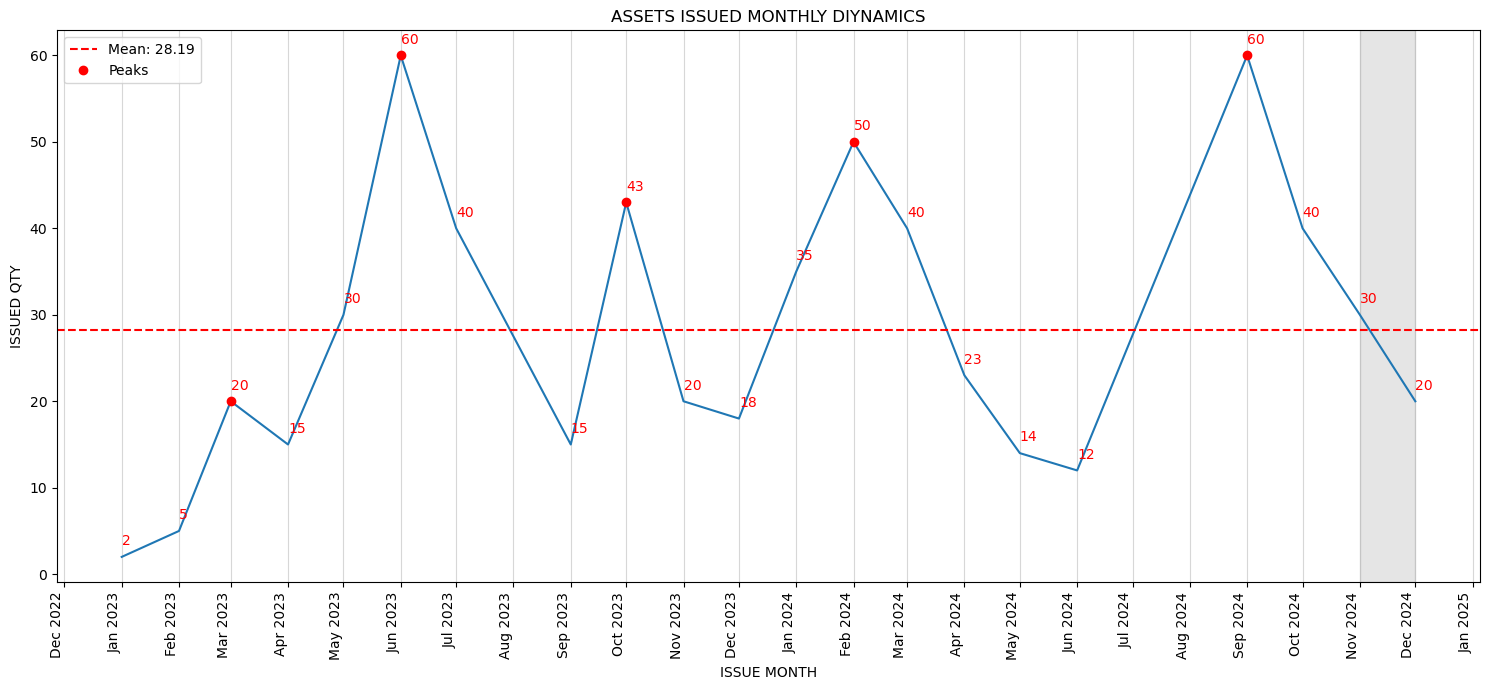

In [13]:
fig, ax= plt.subplots(figsize=(15,7))
ax.plot(monthly_counts3['issue_date'], monthly_counts3['counts'])

ax.set_title('ASSETS ISSUED MONTHLY DIYNAMICS')
ax.set_xlabel('ISSUE MONTH')
ax.set_ylabel('ISSUED QTY')

# Get the maximum x value from the data
max_x_value = monthly_counts3['issue_date'].max()

# Set x-axis major locator to be monthly and formatter to display as month and year
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Place ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2023", etc.

# Calculate the mean of the counts
mean_value = monthly_counts3['counts'].mean()
# Adding a red horizontal line for the mean
ax.axhline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')

# Find peaks: A peak is where the count is greater than the previous and next value
peaks = (monthly_counts3['counts'] > monthly_counts3['counts'].shift(1)) & (monthly_counts3['counts'] > monthly_counts3['counts'].shift(-1))

# Plot the peaks as red dots
ax.plot(monthly_counts3['issue_date'][peaks], monthly_counts3['counts'][peaks], 'ro', label='Peaks')

# Annotate each peak with the corresponding value
for x, y in zip(monthly_counts3['issue_date'], monthly_counts3['counts']):
    ax.text(x, y + 1, str(y), color='red', ha='left', va='bottom')

# Highlight last month
ax.axvspan(max_x_value - pd.Timedelta(days=30), max_x_value , color='#808080', alpha=.2)
# Allign vertical grid lines for each x-axis tick
plt.grid(axis='x', alpha=.5)

fig.autofmt_xdate(rotation=90)
plt.legend(loc=2)
plt.tight_layout()
plt.show()

# Additional tricks

## Aggregation All-In-One

In [98]:
# Шаг 2: Агрегировать по месяцам методом count
monthly_counts = (
    expanded_df.groupby(expanded_df["issue_date"].dt.to_period("D"))["type"]
    .count()
    .reset_index(name="count")
)

### Datetime parse

In [17]:
expanded_df['date'] = [parse(date).date() for date in expanded_df['issue_date']]

### Enrich Dataset with additional timestamps

In [20]:
expanded_df['monthyear'] = pd.to_datetime(expanded_df['date']).dt.to_period('M')

In [21]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   issue_date  592 non-null    object   
 1   type        592 non-null    object   
 2   date        592 non-null    object   
 3   monthyear   592 non-null    period[M]
dtypes: object(3), period[M](1)
memory usage: 18.6+ KB


In [22]:
pd.to_datetime

,issue_date,type,date,monthyear
0,2023-01-01,license,2023-01-01,2023-01
1,2023-01-01,license,2023-01-01,2023-01
2,2023-01-02,license,2023-01-02,2023-01
3,2023-01-02,license,2023-01-02,2023-01
4,2023-01-02,license,2023-01-02,2023-01
...,...,...,...,...
587,2024-01-12,license,2024-01-12,2024-01
588,2024-01-12,license,2024-01-12,2024-01
589,2024-01-12,license,2024-01-12,2024-01
590,2024-01-12,license,2024-01-12,2024-01


In [48]:
monthly_counts

NameError: name 'monthly_counts' is not defined

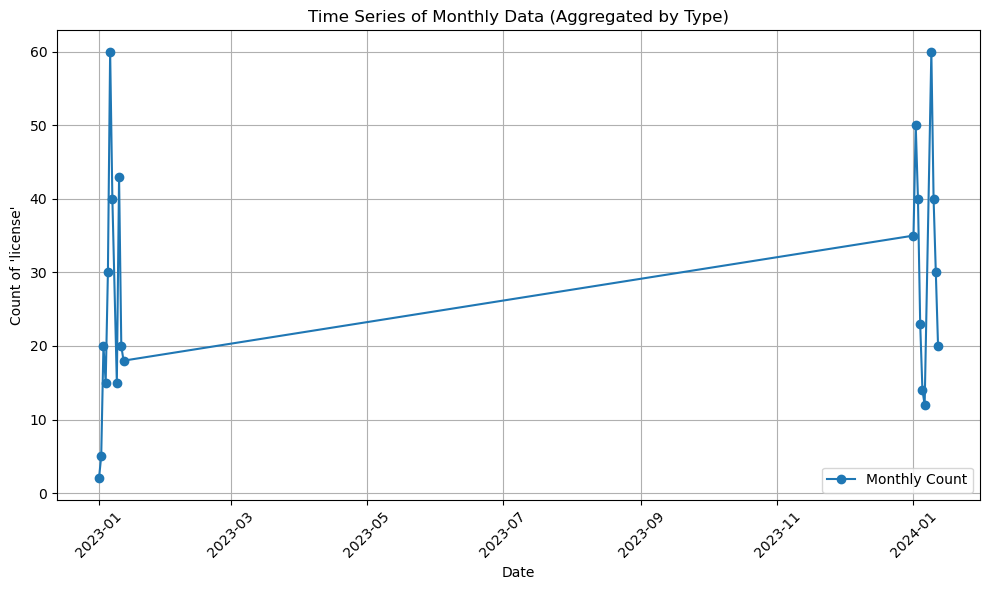

In [57]:
# Шаг 3: Построить график
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts["issue_date"], monthly_counts["count"], marker="o", label="Monthly Count")
plt.title("Time Series of Monthly Data (Aggregated by Type)")
plt.xlabel("Date")
plt.ylabel("Count of 'license'")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

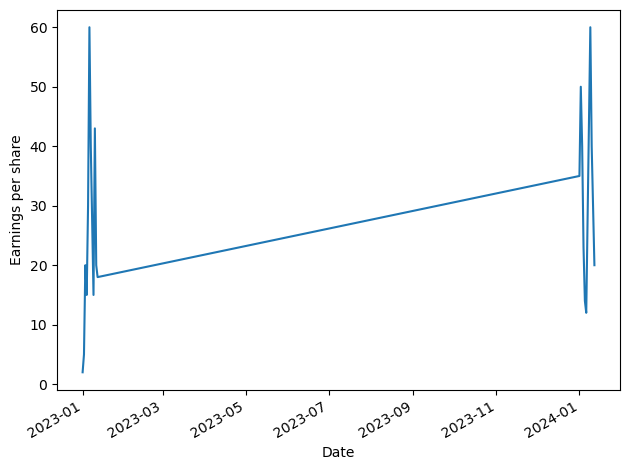

In [58]:
fig, ax= plt.subplots()
ax.plot(monthly_counts['issue_date'], monthly_counts['count'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share')
#ax.axvspan(80,83, color='#808080', alpha=.2)
#plt.xticks(np.arange(0,81,8),[1960,1962,1964,1966,1968,1970,1972,1974,1976,1978,1980])
fig.autofmt_xdate()
plt.tight_layout()